In [1]:
import os
from dotenv import load_dotenv

# Load variables from .env file
load_dotenv()

# Get the API key
user_key = os.getenv("RIOT_API_KEY")
user_puuid = os.getenv("RIOT_PUUID")

In [2]:
import requests 
import pandas as pd
import time

# Raivenomace20 information
puuid = user_puuid 
mass_region = "americas"
# WILL NOT WORK AFTER TODAY. API CHANGES EVERYDAY UNLESS RIOT DEVELOPER WHICH I HAVE NOT BEEN APPROVED OF. SAMPLE STILL REMAINS
api_key = user_key

# The function to get a list of all the match IDs (2nd example above) given a players puuid and mass region
def get_match_ids(puuid, mass_region, api_key):
    api_url_match = (
        "https://" +
        mass_region +
        ".api.riotgames.com/tft/match/v1/matches/by-puuid/" +
        puuid + 
        "/ids?start=0&count=50" + 
        "&api_key=" + 
        api_key
    )
    
    resp = requests.get(api_url_match)
    match_ids = resp.json()
    return match_ids

# From a given match ID and mass region, get the data about the game
def get_match_data(match_id, mass_region, api_key):
    api_url_matchdata = (
        "https://" + 
        mass_region + 
        ".api.riotgames.com/tft/match/v1/matches/" +
        match_id + 
        "?api_key=" + 
        api_key
    )
    
    # we need to add this "while" statement so that we continuously loop until it's successful
    while True:
        resp = requests.get(api_url_matchdata)
        
        # whenever we see a 429, we sleep for 10 seconds and then restart from the top of the "while" loop
        if resp.status_code == 429:
            print("Rate Limit hit, sleeping for 10 seconds")
            time.sleep(10)
            continue
            
        # if resp.status_code isn't 429, then we carry on to the end of  the function and return the data
        match_data = resp.json()
        return match_data


def gather_all_data(puuid, match_ids, mass_region, api_key):
    # We initialise an empty dictionary to store data for each game
    data = {
        'set_number': [],
        'placement': [],
        'level': [],
        'traits': [],
        'units': [],
        'items': []
    }
    
    for match_id in match_ids:
        # run the two functions to get the player data from the match ID
        match_data = get_match_data(match_id, mass_region, api_key)
        # Debug print(match_data)
        set_number = match_data['info']['tft_set_number']
        data['set_number'].append(set_number)
        # assign the variables we're interested in
        index = None
        for pos, id in enumerate(match_data['metadata']['participants']):
            if puuid == id:
                index = pos
                break
        # print(puuid, match_data['metadata']['participants'][index])
        placement = match_data['info']['participants'][index]['placement']
        level = match_data['info']['participants'][index]['level']
        traits = [trait['name'] for trait in match_data['info']['participants'][index]['traits']]
        units = [unit['character_id'] for unit in match_data['info']['participants'][index]['units']]
        items = [item['itemNames'] for item in match_data['info']['participants'][index]['units']]
        # add them to our dataset
        data['placement'].append(placement)
        data['level'].append(level)
        data['traits'].append(traits)
        data['units'].append(units)
        data['items'].append(items)
    
    df = pd.DataFrame(data)
 
    return df

match_ids = get_match_ids(puuid, mass_region, api_key)
df = gather_all_data(puuid, match_ids, mass_region, api_key)
df = df[df['set_number'] == 13].copy()

print(df.head())

    set_number  placement  level  \
14          13          3      9   
15          13          7      9   
16          13          3      8   
17          13          2      9   
19          13          2      9   

                                               traits  \
14  [TFT13_Ambassador, TFT13_Bruiser, TFT13_Cabal,...   
15  [TFT13_Academy, TFT13_Ambassador, TFT13_Bruise...   
16  [TFT13_Ambassador, TFT13_Bruiser, TFT13_Cabal,...   
17  [TFT13_Academy, TFT13_FormSwapper, TFT13_Invok...   
19  [TFT13_Ambusher, TFT13_Bruiser, TFT13_Crime, T...   

                                                units  \
14  [TFT13_Zyra, TFT13_Urgot, TFT13_NunuWillump, t...   
15  [TFT13_Tristana, tft13_swain, TFT13_Nami, TFT1...   
16  [TFT13_Vladimir, TFT13_Tristana, tft13_swain, ...   
17  [TFT13_Irelia, TFT13_Leona, TFT13_Rell, TFT13_...   
19  [TFT13_Singed, TFT13_Rell, TFT13_RenataGlasc, ...   

                                                items  
14  [[], [], [], [], [TFT_Item_Redemption

In [6]:
df.to_excel("tft_analysis.xlsx", index=False)

In [ ]:
""" import requests

url = "https://raw.communitydragon.org/latest/cdragon/tft/en_us.json"
response = requests.get(url)

with open("en_us.json", "w", encoding="utf-8") as f:
    f.write(response.text)

print("Downloaded en_us.json") """

Downloaded en_us.json


In [3]:
import json

# Load the JSON
with open("en_us.json", "r", encoding="utf-8") as f:
    cd_data = json.load(f)

set_number = str(df['set_number'].iloc[0])

# Extract all valid trait definitions
# Based on:
# 1. apiName starts with "TFT#_"
# 2. associatedTraits is not present (so it's not just a reference)
# 3. name and desc exist (i.e. meaningful definition)
# So, it can include outputs that are not only just traits (i.e. augments etc)
def extract_traits(json_obj):
    if isinstance(json_obj, dict):
        if (
            json_obj.get("apiName", "").startswith(f"TFT{set_number}_")
            and "desc" in json_obj
            and not json_obj.get("associatedTraits")
        ):
            yield json_obj
        for v in json_obj.values():
            yield from extract_traits(v)
    elif isinstance(json_obj, list):
        for item in json_obj:
            yield from extract_traits(item)

# Use dictionary to de-duplicate by apiName
trait_map = {}
for trait in extract_traits(cd_data):
    trait_map[trait["apiName"]] = trait["name"]

# Print final deduplicated result
print("Unique TFT13 Traits:\n")
for api, name in sorted(trait_map.items()):
    print(f"{api}: {name}")


Unique TFT13 Traits:

TFT13_Academy: Academy
TFT13_Ambassador: Emissary
TFT13_Ambusher: Ambusher
TFT13_AnotherAnomaly_Item: Portable Anomaly
TFT13_Augment_AGoldenFind: A Golden Find
TFT13_Augment_AnotherAnomaly: Another Anomaly
TFT13_Augment_Grant6Cost_MissMage: A Change Of Fate
TFT13_Augment_Grant6Cost_Viktor: Glorious Evolution
TFT13_Augment_Grant6Cost_Warwick: What You Really Are
TFT13_Augment_GuidedAnomaly: Guided Anomaly
TFT13_BloodHunter: Blood Hunter
TFT13_Bruiser: Bruiser
TFT13_Cabal: Black Rose
TFT13_Challenger: Quickstriker
TFT13_Crime: Chem-Baron
TFT13_Crime_Gold: Gold
TFT13_Experiment: Experiment
TFT13_Family: Family
TFT13_FormSwapper: Form Swapper
TFT13_GoopBuff_Miniaturize_Item: Miniature Champion
TFT13_GoopBuff_VoraciousAppetite_Consumable: A Chromatic Snack
TFT13_Hextech: Automata
TFT13_HighRoller: High Roller
TFT13_Hoverboard: Firelight
TFT13_Infused: Dominator
TFT13_Invoker: Visionary
TFT13_Item_AcademyEmblemItem: Academy Emblem
TFT13_Item_AmbusherEmblemItem: Ambusher

In [4]:
# Manually fix naming as Riot has hidden names for certain traits
manual_trait_map = {
    "TFT13_Warband": "TFT13_Conqueror",
    "TFT13_Pugilist": "Pit Fighter",
    "TFT13_Cabal": "TFT13_Black Rose",
    "TFT13_Ambassador": "TFT13_Emissary",
    "TFT13_BloodHunter": "TFT13_Blood Hunter",
    "TFT13_Challenger": "TFT13_Quickstriker",
    "TFT13_Crime": "TFT13_Chem-Baron",
    "TFT13_FormSwapper": "TFT13_Form Swapper",
    "TFT13_Infused": "TFT13_Dominator",
    "TFT13_Invoker": "TFT13_Visionary",
    "TFT13_JunkerKing": "TFT13_Junker King",
    "TFT13_Martialist": "TFT13_Artillerist",
    "TFT13_Squad": "TFT13_Enforcer",
    "TFT13_Titan": "TFT13_Sentinel"

}

def rename_traits(trait_list):
    renamed = []
    for trait in trait_list:
        key = trait
        if key in manual_trait_map:
            renamed.append(manual_trait_map[key])
        else:
            renamed.append(trait)  # fallback to original if not in map
    return renamed

df['traits_original'] = df['traits'].copy(deep=True)
df['traits_renamed'] = df['traits_original'].apply(rename_traits)

print(df[['traits_original', 'traits_renamed']].head(5))

                                      traits_original  \
14  [TFT13_Ambassador, TFT13_Bruiser, TFT13_Cabal,...   
15  [TFT13_Academy, TFT13_Ambassador, TFT13_Bruise...   
16  [TFT13_Ambassador, TFT13_Bruiser, TFT13_Cabal,...   
17  [TFT13_Academy, TFT13_FormSwapper, TFT13_Invok...   
19  [TFT13_Ambusher, TFT13_Bruiser, TFT13_Crime, T...   

                                       traits_renamed  
14  [TFT13_Emissary, TFT13_Bruiser, TFT13_Black Ro...  
15  [TFT13_Academy, TFT13_Emissary, TFT13_Bruiser,...  
16  [TFT13_Emissary, TFT13_Bruiser, TFT13_Black Ro...  
17  [TFT13_Academy, TFT13_Form Swapper, TFT13_Visi...  
19  [TFT13_Ambusher, TFT13_Bruiser, TFT13_Chem-Bar...  


In [5]:
# Apply renaming to df
df['traits'] = df['traits'].apply(rename_traits)

In [6]:
# TRAITS
import pandas as pd
from collections import Counter

# Step 1: Count all trait appearances
trait_counts = Counter([trait for traits in df['traits'] for trait in traits])

# Step 2: Filter out traits with <=10 total appearances
valid_traits = {trait for trait, count in trait_counts.items() if count > 10}

# Step 3: Create a new column with filtered traits
df['filtered_traits'] = df['traits'].apply(lambda traits: [t for t in traits if t in valid_traits])

# Step 4: Subset into top 4 and bottom 4 using the filtered traits
df_top4_traits = df[df['placement'] <= 4].copy()
df_bot4_traits = df[df['placement'] > 4].copy()


In [7]:
# Win/Lose Percentages
from collections import defaultdict

# Initialize counters
trait_top_count = defaultdict(int)
trait_bot_count = defaultdict(int)
trait_total_count = defaultdict(int)

# Count trait stats across filtered data
for _, row in df.iterrows():
    is_top4 = row['placement'] <= 4
    is_bot4 = not is_top4

    for trait in row['filtered_traits']:
        trait_total_count[trait] += 1
        if is_top4:
            trait_top_count[trait] += 1
        else:
            trait_bot_count[trait] += 1

# Create summary DataFrame
trait_data = []
for trait in trait_total_count:
    top_rate = trait_top_count[trait] / trait_total_count[trait]
    bot_rate = trait_bot_count[trait] / trait_total_count[trait]
    trait_data.append({
        'Trait': trait,
        'Top 4 Rate': top_rate,
        'Bottom 4 Rate': bot_rate,
        'Games Played': trait_total_count[trait]
    })

trait_df = pd.DataFrame(trait_data)

top_4_df = trait_df.sort_values(by='Top 4 Rate', ascending=False).head(10)
print("\nTop 10 Traits (Top 4 Placement):")
print(top_4_df)

bot_4_df = trait_df.sort_values(by='Bottom 4 Rate', ascending=False).head(10)
print("\nTop 10 Traits (Bottom 4 Placement):")
print(bot_4_df)


Top 10 Traits (Top 4 Placement):
                 Trait  Top 4 Rate  Bottom 4 Rate  Games Played
6    TFT13_Junker King    0.714286       0.285714            14
13       TFT13_Academy    0.666667       0.333333            12
3   TFT13_Form Swapper    0.562500       0.437500            16
4      TFT13_Dominator    0.562500       0.437500            16
11      TFT13_Sentinel    0.518519       0.481481            27
16         TFT13_Rebel    0.500000       0.500000            24
15     TFT13_Conqueror    0.500000       0.500000            32
5      TFT13_Visionary    0.500000       0.500000            18
1        TFT13_Bruiser    0.500000       0.500000            12
10      TFT13_Enforcer    0.500000       0.500000            12

Top 10 Traits (Bottom 4 Placement):
                 Trait  Top 4 Rate  Bottom 4 Rate  Games Played
14  TFT13_Quickstriker    0.400000       0.600000            20
12       TFT13_Watcher    0.454545       0.545455            22
8          TFT13_Scrap    0.45454

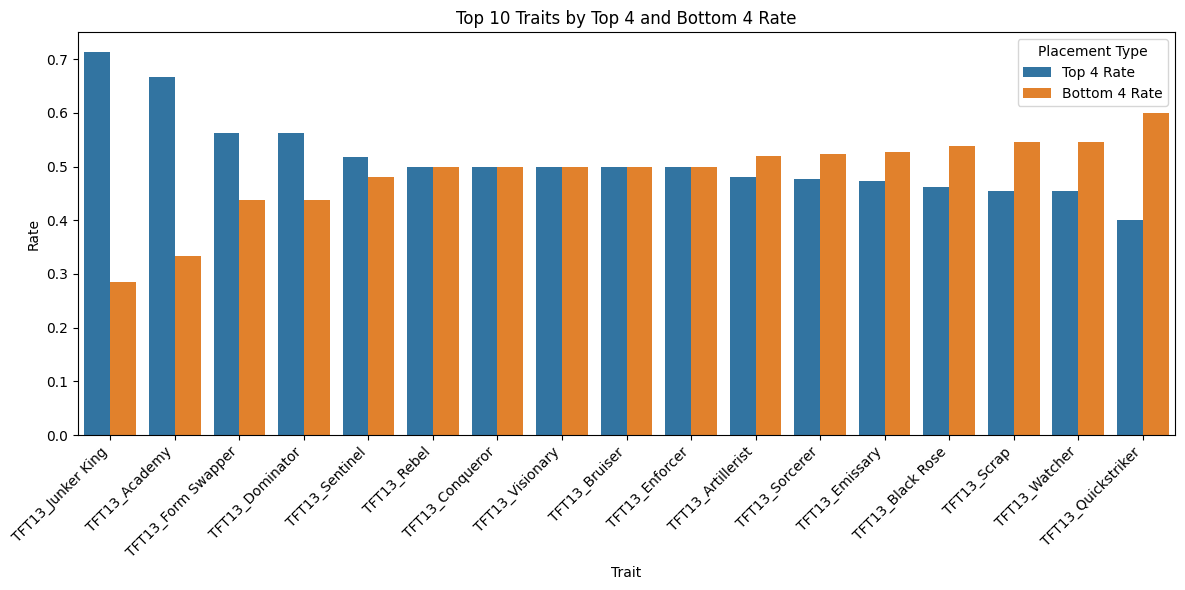

In [ ]:
import matplotlib.pyplot as plt

# Combine the top 10 traits by Top 4 Rate and Bottom 4 Rate to avoid missing data
top_traits = set(top_4_df['Trait']) | set(bot_4_df['Trait'])
plot_df = trait_df[trait_df['Trait'].isin(top_traits)].sort_values('Top 4 Rate', ascending=False)

# Melt DataFrame to long-form for seaborn
plot_long = plot_df.melt(id_vars='Trait', value_vars=['Top 4 Rate', 'Bottom 4 Rate'],
                         var_name='Placement Type', value_name='Rate')

# Plot
plt.figure(figsize=(12, 6))
import seaborn as sns
sns.barplot(data=plot_long, x='Trait', y='Rate', hue='Placement Type')

plt.title('Top 10 Traits by Top 4 and Bottom 4 Rate')
plt.ylabel('Rate')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [13]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

def run_apriori_traits(df_subset, min_support=0.4, max_confidence=0.99, df_all=None):

    transactions = df_subset['filtered_traits'].tolist()

    # Encode transactions
    te = TransactionEncoder()
    te_array = te.fit_transform(transactions)
    trait_matrix = pd.DataFrame(te_array, columns=te.columns_)

    # Apriori
    frequent_itemsets = apriori(trait_matrix, min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

    # Filter bad rules
    rules = rules[
        (rules['confidence'] < max_confidence) &
        (rules['antecedents'] != rules['consequents']) &
        rules.apply(lambda row: row['antecedents'].isdisjoint(row['consequents']), axis=1)
    ]

    # Add Top 4 / Bottom 4 rate for rule combinations
    if df_all is not None:
        top4_set = df_all[df_all['placement'] <= 4]['filtered_traits']
        bot4_set = df_all[df_all['placement'] > 4]['filtered_traits']

        def calc_rate(row_set, traits):
            return sum(set(traits).issubset(set(r)) for r in row_set) / len(row_set)

        top4_rates = []
        bot4_rates = []

        for _, rule in rules.iterrows():
            traits = sorted(rule['antecedents'] | rule['consequents'])
            top4_rates.append(calc_rate(top4_set, traits))
            bot4_rates.append(calc_rate(bot4_set, traits))

        rules['Top 4 Rate'] = top4_rates
        rules['Bottom 4 Rate'] = bot4_rates

    return rules[['antecedents', 'consequents', 'support', 'confidence', 'lift', 'Top 4 Rate', 'Bottom 4 Rate']].sort_values(by='Top 4 Rate', ascending=False)

# Use the full dataset as `df_all` for context
top4_rules_df = run_apriori_traits(df_top4_traits, df_all=df)
print(top4_rules_df.head())
bot4_rules_df = run_apriori_traits(df_bot4_traits, df_all=df)
print(bot4_rules_df.head())

                           antecedents                     consequents  \
33                   (TFT13_Conqueror)                   (TFT13_Rebel)   
297                   (TFT13_Sentinel)  (TFT13_Rebel, TFT13_Conqueror)   
295  (TFT13_Sentinel, TFT13_Conqueror)                   (TFT13_Rebel)   
299                  (TFT13_Conqueror)   (TFT13_Sentinel, TFT13_Rebel)   
70                    (TFT13_Sentinel)                   (TFT13_Rebel)   

      support  confidence      lift  Top 4 Rate  Bottom 4 Rate  
33   0.705882    0.750000  1.062500    0.705882       0.555556  
297  0.705882    0.857143  1.214286    0.705882       0.555556  
295  0.705882    0.923077  1.307692    0.705882       0.555556  
299  0.705882    0.750000  1.062500    0.705882       0.555556  
70   0.705882    0.857143  1.214286    0.705882       0.611111  
                           antecedents        consequents   support  \
18                    (TFT13_Sentinel)  (TFT13_Conqueror)  0.666667   
19                   (T

In [15]:
# Apriori used for user selecting trait and commonly related traits is then showed

In [18]:
#ITEMS
# Step 1: Flatten all items and count appearances
item_counts = Counter(
    item
    for item_lists in df['items']
    for unit_items in item_lists
    for item in unit_items
)

# Step 2: Filter out items with <=10 total appearances
valid_items = {item for item, count in item_counts.items() if count > 10}

# Step 3: Create a new column with filtered items per game
def filter_items(item_lists):
    return [[item for item in unit_items if item in valid_items] for unit_items in item_lists]

df['filtered_items'] = df['items'].apply(filter_items)

# Step 4: Subset into top 4 and bottom 4 using the filtered items
df_top4_items = df[df['placement'] <= 4].copy()
df_bot4_items = df[df['placement'] > 4].copy()


In [19]:
# Initialize counters
item_top_count = defaultdict(int)
item_bot_count = defaultdict(int)
item_total_count = defaultdict(int)

# Count item stats across filtered_items
for _, row in df.iterrows():
    is_top4 = row['placement'] <= 4

    for unit_items in row['filtered_items']:
        for item in unit_items:
            item_total_count[item] += 1
            if is_top4:
                item_top_count[item] += 1
            else:
                item_bot_count[item] += 1

# Create summary DataFrame
item_data = []
for item in item_total_count:
    total = item_total_count[item]
    top_rate = item_top_count[item] / total
    bot_rate = item_bot_count[item] / total
    item_data.append({
        'Item': item,
        'Top 4 Rate': round(top_rate, 4),
        'Bottom 4 Rate': round(bot_rate, 4),
        'Games Played': total
    })

item_df = pd.DataFrame(item_data)

# Show Top 10 by Top 4 Rate
top_4_items_df = item_df.sort_values(by='Top 4 Rate', ascending=False).head(10)
print("\nTop 10 Items (Top 4 Placement):")
print(top_4_items_df)

# Show Top 10 by Bottom 4 Rate
bot_4_items_df = item_df.sort_values(by='Bottom 4 Rate', ascending=False).head(10)
print("\nTop 10 Items (Bottom 4 Placement):")
print(bot_4_items_df)



Top 10 Items (Top 4 Placement):
                           Item  Top 4 Rate  Bottom 4 Rate  Games Played
5      TFT_Item_JeweledGauntlet      0.6875         0.3125            16
3   TFT_Item_GargoyleStoneplate      0.6364         0.3636            22
7        TFT_Item_SpearOfShojin      0.6316         0.3684            19
10           TFT_Item_Leviathan      0.6154         0.3846            13
9        TFT_Item_TitansResolve      0.5833         0.4167            12
11     TFT_Item_ArchangelsStaff      0.5833         0.4167            12
1              TFT_Item_RedBuff      0.5500         0.4500            20
8        TFT_Item_GuardianAngel      0.5455         0.4545            11
2         TFT_Item_WarmogsArmor      0.5172         0.4828            29
0           TFT_Item_Redemption      0.5000         0.5000            16

Top 10 Items (Bottom 4 Placement):
                           Item  Top 4 Rate  Bottom 4 Rate  Games Played
12       TFT_Item_Bloodthirster      0.4167         0.5

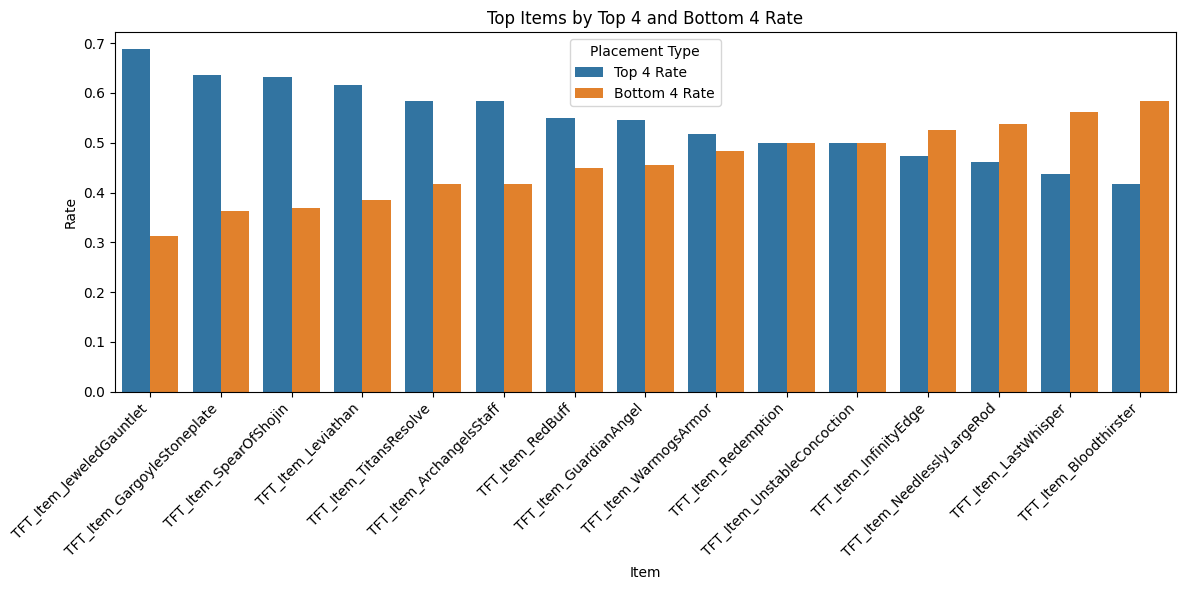

In [20]:
# Combine top and bottom item sets to avoid missing bars
top_items = set(top_4_items_df['Item']) | set(bot_4_items_df['Item'])
plot_items_df = item_df[item_df['Item'].isin(top_items)].sort_values('Top 4 Rate', ascending=False)

# Melt to long format for grouped bar plot
plot_items_long = plot_items_df.melt(id_vars='Item', value_vars=['Top 4 Rate', 'Bottom 4 Rate'],
                                     var_name='Placement Type', value_name='Rate')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=plot_items_long, x='Item', y='Rate', hue='Placement Type')

plt.title('Top Items by Top 4 and Bottom 4 Rate')
plt.ylabel('Rate')
plt.xlabel('Item')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
def run_apriori_items(df_subset, min_support=0.4, max_confidence=0.99, df_all=None):
    # Flatten unit-level item lists into one list per match
    transactions = [
        [item for unit_items in match_items for item in unit_items]
        for match_items in df_subset['filtered_items']
    ]

    # Encode transactions
    te = TransactionEncoder()
    te_array = te.fit_transform(transactions)
    item_matrix = pd.DataFrame(te_array, columns=te.columns_)

    # Apriori
    frequent_itemsets = apriori(item_matrix, min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

    # Filter redundant or overlapping rules
    rules = rules[
        (rules['confidence'] < max_confidence) &
        (rules['antecedents'] != rules['consequents']) &
        rules.apply(lambda row: row['antecedents'].isdisjoint(row['consequents']), axis=1)
    ]

    # Add Top 4 / Bottom 4 rate
    if df_all is not None:
        top4_set = [
            [item for unit_items in match_items for item in unit_items]
            for match_items in df_all[df_all['placement'] <= 4]['filtered_items']
        ]
        bot4_set = [
            [item for unit_items in match_items for item in unit_items]
            for match_items in df_all[df_all['placement'] > 4]['filtered_items']
        ]

        def calc_rate(row_set, traits):
            return sum(set(traits).issubset(set(r)) for r in row_set) / len(row_set)

        top4_rates = []
        bot4_rates = []

        for _, rule in rules.iterrows():
            itemset = sorted(rule['antecedents'] | rule['consequents'])
            top4_rates.append(calc_rate(top4_set, itemset))
            bot4_rates.append(calc_rate(bot4_set, itemset))

        rules['Top 4 Rate'] = top4_rates
        rules['Bottom 4 Rate'] = bot4_rates

    return rules[['antecedents', 'consequents', 'support', 'confidence', 'lift', 'Top 4 Rate', 'Bottom 4 Rate']].sort_values(by='Top 4 Rate', ascending=False)

top4_rules_df = run_apriori_items(df_top4_items, df_all=df)
print(top4_rules_df.head())
bot4_rules_df = run_apriori_items(df_bot4_items, df_all=df)
print(bot4_rules_df.head())


                     antecedents                    consequents   support  \
2  (TFT_Item_GargoyleStoneplate)        (TFT_Item_WarmogsArmor)  0.529412   
3        (TFT_Item_WarmogsArmor)  (TFT_Item_GargoyleStoneplate)  0.529412   
7        (TFT_Item_InfinityEdge)        (TFT_Item_WarmogsArmor)  0.470588   
6        (TFT_Item_WarmogsArmor)        (TFT_Item_InfinityEdge)  0.470588   
8             (TFT_Item_RedBuff)     (TFT_Item_JeweledGauntlet)  0.470588   

   confidence      lift  Top 4 Rate  Bottom 4 Rate  
2    0.900000  1.092857    0.529412       0.222222  
3    0.642857  1.092857    0.529412       0.222222  
7    0.888889  1.079365    0.470588       0.277778  
6    0.571429  1.079365    0.470588       0.277778  
8    0.727273  1.236364    0.470588       0.055556  
                     antecedents                    consequents   support  \
5  (TFT_Item_UnstableConcoction)       (TFT_Item_Bloodthirster)  0.444444   
4       (TFT_Item_Bloodthirster)  (TFT_Item_UnstableConcoction)  

In [21]:
# Apriori used for user selecting trait and commonly related traits is then showed

In [22]:
# UNITS
import pandas as pd

# Convert stringified lists to actual lists
df['filtered_traits'] = df['filtered_traits'].apply(lambda x: eval(x) if isinstance(x, str) else x)
df['units'] = df['units'].apply(lambda x: eval(x) if isinstance(x, str) else x)
df['filtered_items'] = df['filtered_items'].apply(lambda x: eval(x) if isinstance(x, str) else x)

unit_rows = []

for _, row in df.iterrows():
    active_traits = row['filtered_traits']
    placement = row['placement']
    units = row['units']
    items_per_unit = row['filtered_items']

    for unit_name, item_list in zip(units, items_per_unit):
        # Pad/truncate item list to 3
        item_list = item_list[:3] + [None] * (3 - len(item_list))
        unit_rows.append({
            'unit': unit_name,
            'item_1': item_list[0],
            'item_2': item_list[1],
            'item_3': item_list[2],
            'placement': placement,
            'traits': active_traits
        })

unit_df = pd.DataFrame(unit_rows)

unit_df


,unit,item_1,item_2,item_3,placement,traits
0,TFT13_Zyra,None,None,None,3,"[TFT13_Emissary, TFT13_Bruiser, TFT13_Black Ro..."
1,TFT13_Urgot,None,None,None,3,"[TFT13_Emissary, TFT13_Bruiser, TFT13_Black Ro..."
2,TFT13_NunuWillump,None,None,None,3,"[TFT13_Emissary, TFT13_Bruiser, TFT13_Black Ro..."
3,tft13_elise,None,None,None,3,"[TFT13_Emissary, TFT13_Bruiser, TFT13_Black Ro..."
4,TFT13_Garen,TFT_Item_Redemption,None,None,3,"[TFT13_Emissary, TFT13_Bruiser, TFT13_Black Ro..."
...,...,...,...,...,...,...
302,TFT13_DrMundo,TFT_Item_WarmogsArmor,None,None,1,"[TFT13_Black Rose, TFT13_Dominator, TFT13_Visi..."
303,TFT13_Malzahar,TFT_Item_SpearOfShojin,None,None,1,"[TFT13_Black Rose, TFT13_Dominator, TFT13_Visi..."
304,TFT13_LeBlanc,TFT_Item_SpearOfShojin,None,None,1,"[TFT13_Black Rose, TFT13_Dominator, TFT13_Visi..."
305,TFT13_Mordekaiser,None,None,None,1,"[TFT13_Black Rose, TFT13_Dominator, TFT13_Visi..."


In [27]:
# Pull native traits of a unit by scanning en_us.json
def get_unit_traits_from_data(unit_name, cd_data):
    def find_unit(obj):
        if isinstance(obj, dict):
            if obj.get("apiName") == unit_name and "traits" in obj:
                return obj["traits"]
            for v in obj.values():
                result = find_unit(v)
                if result:
                    return result
        elif isinstance(obj, list):
            for item in obj:
                result = find_unit(item)
                if result:
                    return result
        return []

    return find_unit(cd_data)

def analyze_unit(unit_df, unit_name, cd_data, top_n=10, min_games=3):
    df = unit_df[unit_df['unit'] == unit_name].copy()
    print(f"\nAnalyzing Unit: {unit_name}")
    print(f"Total Games Found: {len(df)}")
    
    if len(df) < min_games:
        print(f"Not enough games to analyze (min required: {min_games})")
        return None

    # ---- Item Combinations (1-3 item sets) ----
    from itertools import combinations
    item_combo_rows = []
    for _, row in df.iterrows():
        items = [i for i in [row['item_1'], row['item_2'], row['item_3']] if i]
        for r in range(1, len(items) + 1):
            for combo in combinations(sorted(items), r):
                item_combo_rows.append({
                    'items': ' | '.join(combo),
                    'placement': row['placement']
                })

    item_combo_df = pd.DataFrame(item_combo_rows)
    item_stats = (
    item_combo_df.groupby('items')['placement']
    .agg(['mean', 'count'])
    .reset_index()
    )

    # Filter: only show combos seen in at least 5 games
    item_stats = item_stats[item_stats['count'] >= 5]

    # Sort and take top N
    item_stats = item_stats.sort_values('mean').head(top_n).reset_index(drop=True)


    print("\nTop Item Combinations (1–3 items) by Avg Placement:")
    for idx, row in item_stats.iterrows():
        print(f"{idx+1}. {row['items']} — Avg Placement: {row['mean']:.2f} (Games: {int(row['count'])})")

    # ---- Trait Performance (filtering out native traits) ----
    df_exploded = df.explode('traits')

    # Normalize trait names by removing 'TFT13_'
    df_exploded['traits'] = df_exploded['traits'].str.replace('TFT13_', '')

    # Then exclude the native traits
    native_traits = get_unit_traits_from_data(unit_name, cd_data)
    df_exploded = df_exploded[~df_exploded['traits'].isin(native_traits)]

    trait_stats = (
        df_exploded.groupby('traits')['placement']
        .agg(['mean', 'count'])
        .reset_index()
        .sort_values('mean')
        .head(top_n)
        .reset_index(drop=True)
    )

    print("\nTop Traits (excluding unit's native traits):")
    for idx, row in trait_stats.iterrows():
        print(f"{idx+1}. {row['traits']} — Avg Placement: {row['mean']:.2f} (Games: {int(row['count'])})")

    return {
        'item_analysis': item_stats,
        'trait_analysis': trait_stats
    }

result = analyze_unit(unit_df, 'TFT13_Ambessa', cd_data)



Analyzing Unit: TFT13_Ambessa
Total Games Found: 17

Top Item Combinations (1–3 items) by Avg Placement:
1. TFT_Item_TitansResolve — Avg Placement: 3.60 (Games: 5)
2. TFT_Item_GuardianAngel — Avg Placement: 4.71 (Games: 7)
3. TFT_Item_Bloodthirster | TFT_Item_GuardianAngel — Avg Placement: 5.00 (Games: 6)
4. TFT_Item_Bloodthirster — Avg Placement: 5.00 (Games: 12)

Top Traits (excluding unit's native traits):
1. Academy — Avg Placement: 3.25 (Games: 4)
2. Junker King — Avg Placement: 3.88 (Games: 8)
3. Form Swapper — Avg Placement: 3.88 (Games: 8)
4. Bruiser — Avg Placement: 4.00 (Games: 5)
5. Dominator — Avg Placement: 4.25 (Games: 8)
6. Enforcer — Avg Placement: 4.50 (Games: 2)
7. Watcher — Avg Placement: 4.56 (Games: 16)
8. Rebel — Avg Placement: 4.69 (Games: 13)
9. Sentinel — Avg Placement: 4.69 (Games: 13)
10. Artillerist — Avg Placement: 4.94 (Games: 16)
